In [563]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u

from astropy.io import fits

import sys
sys.path
sys.path.append('../../scenes/')
import syndiff as sd 

sys.path.append('../../../tess/tessffi/')
import tess_bkgsub_class as bk
foot = pd.read_csv('../../../tess/tess_pointings.csv')

In [110]:
ra = 247.3989458+.05
dec = 52.93155833+.1
tpf = sd.Get_TESS(ra,dec,90)

/Users/rridden/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [46]:
f = tpf.wcs.calc_footprint()

In [564]:
np.

ValueError: cannot convert float NaN to integer

In [5]:
from astroquery.vizier import Vizier

def Get_Catalogue(tpf, Catalog = 'ps1'):
    """
    Get the coordinates and mag of all sources in the field of view from a specified catalogue.


    I/347/gaia2dis   Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)

    -------
    Inputs-
    -------
        tpf 				class 	target pixel file lightkurve class
        Catalogue 			str 	Permitted options: 'gaia', 'dist', 'ps1'

    Outputs
    -------
        result : pandas table

    """
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.

    Vizier.ROW_LIMIT = -1
    if Catalog == 'gaia':
        catalog = "I/345/gaia2"
    elif Catalog == 'ps1':
        catalog = "II/349/ps1"
    else:
        raise ValueError("{} not recognised as a catalog. Available options: 'gaia', 'dist','ps1'")

    result = Vizier.query_region(c1, catalog=[catalog],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    #too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message
    result = result[catalog].to_pandas()
    
    return result 

In [6]:
Vizier.query_constraints()

Empty TableList

In [25]:
c = SkyCoord(0*u.deg,0*u.deg)
cols = ['RAJ2000','DEJ2000','imag']

a = Vizier(catalog = "II/349/ps1",row_limit=-1,columns=cols).query_constraints()

.query_region(c,radius=1*u.deg)[0].to_pandas()
a = a.iloc[a['imag'].values < 10]

In [ ]:
cols = ['RAJ2000','DEJ2000','imag']

In [173]:
def PS1_cat(wcs):
    f = wcs.calc_footprint()
    ralim = str(min(f[:,0])) + '..' + str(max(f[:,0]))
    declim = str(min(f[:,1])) + '..' + str(max(f[:,1]))
    a = Vizier(catalog = "II/349/ps1",row_limit=-1,
               columns=cols).query_constraints(imag='<=17',RAJ2000=ralim,DEJ2000=declim)[0].to_pandas()
    #r = a.RAJ2000.values
    #d = a.DEJ2000.values
    #p = tpf.wcs.all_world2pix(r,d,0)
    #good = ((p[0]>=0) & (p[1]>=0) & (p[0]>=0))
    return a

In [174]:
a =PS1_cat(tpf.wcs)

In [175]:
r = a.RAJ2000.values
d = a.DEJ2000.values
p = tpf.wcs.all_world2pix(r,d,0)

<IPython.core.display.Javascript object>


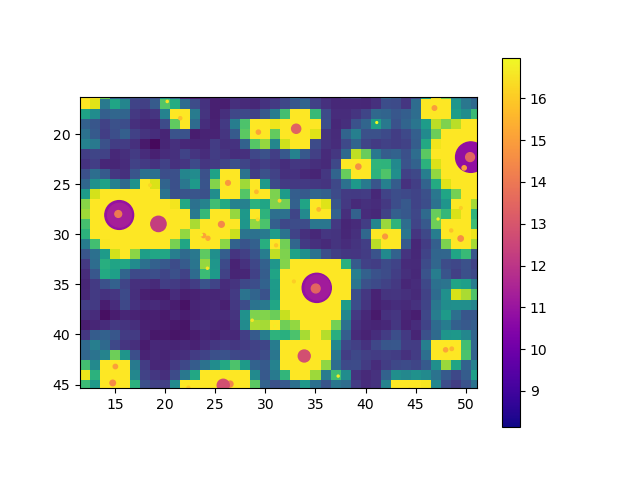

In [176]:
plt.figure()
plt.viridis()
plt.imshow(tpf.flux[0],vmax=80)
eh = plt.scatter(p[0],p[1],s=10**(-2/5*(a['imag']-25))/1e3,c=a['imag'],cmap='plasma')
plt.colorbar(eh)

In [92]:
x = [19,17,16,13,10]
y = [1,3,4,5,6]

<IPython.core.display.Javascript object>


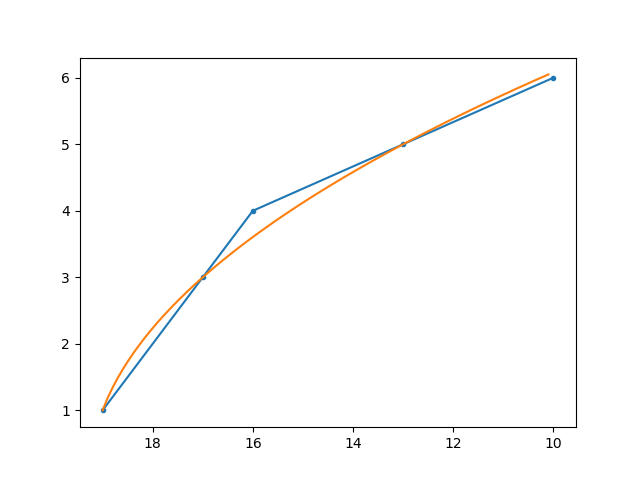

In [109]:
xx = np.arange(19,10,-.1)
yy = np.sqrt(4*(19-xx)+1)
plt.figure()
plt.plot(x,y,'.-')
plt.plot(xx,yy)
plt.gca().invert_xaxis()

In [103]:
xx

array([], dtype=float64)

In [161]:
r = np.sqrt(2*(19-a.imag.values)+1)

In [124]:
(r+.5).astype(int)

array([3, 3, 4, ..., 5, 1, 2])

In [125]:
r

array([3.39688092, 2.66833281, 3.93522553, ..., 5.01756913, 1.37753403,
       2.23123284])

In [177]:
tx = np.arange(0,tpf.shape[1])
ty = np.arange(0,tpf.shape[2])
tx,ty = np.meshgrid(tx,ty)
dists = ((tx[np.newaxis,:,:] - p[0][:,np.newaxis,np.newaxis])**2 +  (ty[np.newaxis,:,:] - p[1][:,np.newaxis,np.newaxis])**2)
r = np.sqrt(1*(19-a.imag.values)+1)
bol = dists <= r[:,np.newaxis,np.newaxis]**2

In [139]:
dists.shape

(1243, 90, 90)

<IPython.core.display.Javascript object>


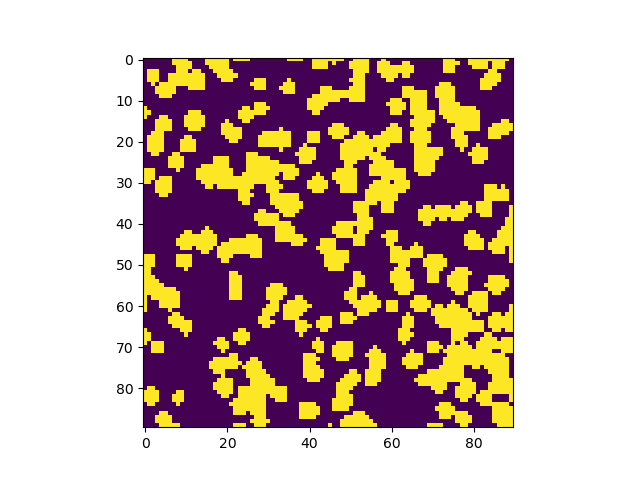

<IPython.core.display.Javascript object>


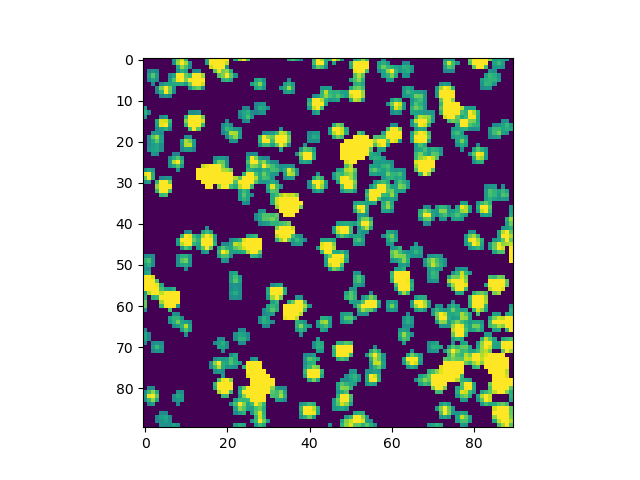

In [180]:
plt.figure()
plt.imshow(np.nansum(bol,axis=0)>0)

plt.figure()
plt.imshow((np.nansum(bol,axis=0)>0)*1 * tpf.flux[100],vmin=50,vmax=100)

In [141]:
tx.shape

(90, 90)

In [134]:
r.shape

(1243,)

In [ ]:
dists

In [1071]:
import mastcasjobs




def PS1cat(wcs):
    jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
    s = wcs.array_shape
    ra, dec = wcs.all_pix2world(s[0]/2,s[1]/2,0)
    r = ((1/2*np.sqrt(s[0]**2+s[1]**2) + 5) * 24)/60
    
    f = wcs.calc_footprint()
    
    ramin = min(f[:,0])
    ramax = max(f[:,0])
    decmin = min(f[:,1])
    decmax = max(f[:,1])

    queryMean = """select 
    o.raMean, o.decMean,o.iMeanPSFMag,o.zMeanPSFMag,o.iMeanKronMag,soa.iKronRad
    from fGetNearbyObjEq({ra},{dec},{rad}) x
    JOIN MeanObjectView o on o.ObjID=x.ObjId
    LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
    WHERE o.nDetections>5
    AND soa.primaryDetection>0
    AND o.raMean > {ramin} and o.raMean < {ramax} and o.decMean > {decmin} and o.decMean < {decmax}
    AND o.iMeanPSFMag <19
    """.format(ra=ra,dec=dec,rad=r,ramin=ramin,ramax=ramax,decmin=decmin,decmax=decmax)

    meanResults = jobs.quick(queryMean, task_name="python mean table search").to_pandas()

    #data = [list(i) for i in meanResults]
    #columns = list(meanResults.columns)

    df = meanResults#pd.DataFrame(data=data,columns=columns)
    df = df.replace(-999,np.nan)
    return df



#select r.*
#from refcat2 as r
#inner join fGetObjFromRect(0,0.2,0,0.2) 

#from fGetNearbyObjEq(0,0,5.0/60.0) as n
#inner join refcat2 as r on n.objid=r.objid

#select ndistance as dstDegrees, r.*
#from fGetNearbyObjEq(0,0,5.0/60.0) as n
#inner join refcat2 as r on n.objid=r.objid
#order by n.distance
def Refcat(wcs):
    jobs = mastcasjobs.MastCasJobs(context="HLSP_ATLAS_REFCAT2")
    s = wcs.array_shape
    ra, dec = wcs.all_pix2world(s[0]/2,s[1]/2,0)
    r = ((1/2*np.sqrt(s[0]**2+s[1]**2) + 5) * 24)/60
    
    f = wcs.calc_footprint()
    
    ramin = min(f[:,0])
    ramax = max(f[:,0])
    decmin = min(f[:,1])
    decmax = max(f[:,1])

    queryMean = """select r.RA, r.Dec, r.Gaia, r.i, r.z
    from fGetNearbyObjEq({ra},{dec},{rad}) as n
    INNER JOIN refcat2 as r on n.objid=r.objid
    WHERE r.i < 13
    """.format(ra=ra,dec=dec,rad=r,ramin=ramin,ramax=ramax,decmin=decmin,decmax=decmax)

    meanResults = jobs.quick(queryMean, task_name="python mean table search").to_pandas()

    #data = [list(i) for i in meanResults]
    #columns = list(meanResults.columns)

    df = meanResults#pd.DataFrame(data=data,columns=columns)
    df = df.replace(-999,np.nan)
    return df


def Gaiacat(wcs):
    jobs = mastcasjobs.MastCasJobs(context="GAIA_EDR3")
    s = wcs.array_shape
    ra, dec = wcs.all_pix2world(s[0]/2,s[1]/2,0)
    r = ((1/2*np.sqrt(s[0]**2+s[1]**2) + 5) * 24)/60
    
    f = wcs.calc_footprint()
    
    ramin = min(f[:,0])
    ramax = max(f[:,0])
    decmin = min(f[:,1])
    decmax = max(f[:,1])

    queryMean = """select T.ra,T.dec,T.phot_g_mean_mag as gaia
    from fGetNearbyObjEq({ra},{dec},{rad}) as n
    join GAIApublicVOview T on T.source_id = n.objID
    WHERE T.phot_g_mean_mag < 14
    """.format(ra=ra,dec=dec,rad=r,ramin=ramin,ramax=ramax,decmin=decmin,decmax=decmax)

    meanResults = jobs.quick(queryMean, task_name="python mean table search").to_pandas()

    #data = [list(i) for i in meanResults]
    #columns = list(meanResults.columns)

    df = meanResults#pd.DataFrame(data=data,columns=columns)
    df = df.replace(-999,np.nan)
    return df

#    INNER JOIN refcat2 as r on n.objid=r.objid
#    WHERE r.i < 13
#AND o.raMean > {ramin} and o.raMean < {ramax} and o.decMean > {decmin} and o.decMean < {decmax}
#    AND o.iMeanPSFMag <14

In [1038]:
a = Gaiacat(cut.wcs)

In [1039]:
a

,ra,dec,gaia
0,189.056672,8.463736,12.85162
1,189.172460,8.445091,13.26637
2,189.054313,8.229342,11.65967
3,189.035591,8.238851,13.79077
4,189.076588,8.342690,12.17321
...,...,...,...
244,189.416515,9.199196,13.32862
245,189.498890,9.194605,12.62090
246,189.118555,9.016619,13.47427
247,189.078394,9.051291,13.34594


In [213]:
s = wcs.array_shape
ra, dec = wcs.all_pix2world(s[0]/2,s[1]/2,0)
((1/2*np.sqrt(s[0]**2+s[1]**2) + 5) * 24)/60

598.0060402378487

In [219]:
from astropy.nddata import Cutout2D

In [1055]:
file = '../../../../data/tess/pipe/test/s0023_58939.901_0591_3.sw.fits'
#f = fits.open('../../../../data/tess/pipe/test/s0023_58939.901_0591_3.sw.diff.fits')[0].data
f = fits.open(file)[0].data
hdu = fits.open(file)[0]
mask = fits.open('../../../../data/tess/pipe/test/s0023_58939.901_0591_3.sw.mask.fits')[0].data
f2 = fits.open('../../../../data/tess/pipe/test/s0023_58929.380_0086_3.sw.diff.fits')[0].data
wcs = WCS(file)
wcs2 = WCS('../../../../data/tess/pipe/test/s0023_58929.380_0086_3.sw.diff.fits')

In [1043]:
cut = Cutout2D(f,(1000,1000),200,wcs=wcs)
m = Cutout2D(mask,(1000,1000),200,wcs=wcs)
#cut = Cutout2D(cut.data,(178,10),50,wcs=cut.wcs)

In [1061]:
start = hdu.header['SCCSA']-1
end = hdu.header['SCCED']

In [1064]:
a = Cutout2D(f,(1024+start,1024),2024)

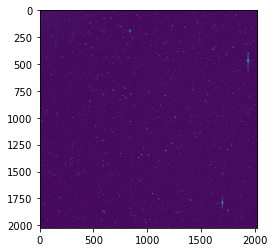

In [1070]:
%matplotlib inline
plt.figure()
plt.imshow(a.data)


In [1052]:
cut = Cutout2D(f,(1000,1000),128,wcs=wcs)
ps1 = PS1_mean_detections(cut.wcs)
gaia = Gaiacat(cut.wcs)

In [1075]:
image = fits.open(file)[0].data
hdu = fits.open(file)[0]

number = 16
width = 2048/number
ps1 = None
for i in range(number-1):
    sr = i*width
    se = (i+1)* width
    for j in range(number-1):
        sc = start+j*width
        ec = start+(j+1)*width
        FFI_wcs = WCS(hdu.header)
        Main_cutout = Cutout2D(image,(1024+start,1024),2024,wcs=FFI_wcs)
        rowcent = sr + (width/2 - 0.5)
        colcent = sc + (width/2 - 0.5)
        print(colcent,rowcent)
        temp = Cutout2D(data,(colcent,rowcent),width,wcs=Main_cutout.wcs)
        wcs = temp.wcs
        p = PS1cat(wcs)
        if ps1 is None:
            ps1 = p
            print('added first region')
        else:
            ps1 = ps1.append(p)
            ps1 = ps1.drop_duplicates()
            print('added next region')

107.5 63.5
added first region
235.5 63.5
added next region
363.5 63.5
added next region
491.5 63.5
added next region
619.5 63.5
added next region
747.5 63.5
added next region
875.5 63.5
added next region
1003.5 63.5
added next region
1131.5 63.5
added next region
1259.5 63.5
added next region
1387.5 63.5
added next region
1515.5 63.5
added next region
1643.5 63.5
added next region
1771.5 63.5
added next region
1899.5 63.5
added next region
107.5 191.5
added next region
235.5 191.5
added next region
363.5 191.5
added next region
491.5 191.5
added next region
619.5 191.5
added next region
747.5 191.5
added next region
875.5 191.5
added next region
1003.5 191.5
added next region
1131.5 191.5
added next region
1259.5 191.5
added next region
1387.5 191.5
added next region
1515.5 191.5
added next region
1643.5 191.5
added next region
1771.5 191.5
added next region
1899.5 191.5
added next region
107.5 319.5
added next region
235.5 319.5
added next region
363.5 319.5
added next region
491.5 31

In [1076]:
ps1

,raMean,decMean,iMeanPSFMag,zMeanPSFMag,iMeanKronMag,iKronRad
0,183.591795,5.010405,15.4516,15.1383,15.5194,2.92600
1,183.612160,5.012040,18.0943,17.8769,18.1748,3.21380
2,183.612798,5.015850,13.5680,13.2743,13.5916,3.26767
3,183.753157,5.014235,16.6619,16.8448,15.9739,8.49608
4,183.759954,5.013598,17.9191,17.6973,17.3118,4.91676
...,...,...,...,...,...,...
1766,197.198889,10.759699,18.7006,18.6961,18.7993,2.35677
1767,197.225003,10.761972,17.9673,17.8109,18.0620,2.66784
1768,197.310583,10.759914,18.5427,17.9036,18.6552,2.24898
1769,197.327154,10.759766,16.4027,16.3042,16.4682,2.74545


In [1046]:
bk_mask = bk.Source_mask(f.astype('float'))

IndexError: cannot do a non-empty take from an empty axes.

In [529]:
sources.iKronRad.max()

39.8631

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f90a33f57a0> (for post_execute):


KeyboardInterrupt: 

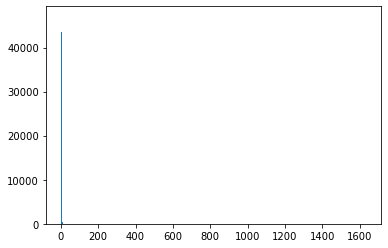

In [1079]:
plt.figure()
plt.hist(ps1.iKronRad,bins=10000);

In [ ]:
dat = cut.data

r = ps1.raMean.values
d = ps1.decMean.values
p = wcs.all_world2pix(r,d,0)
tx = np.arange(0,f.shape[0])
ty = np.arange(0,f.shape[1])
tx,ty = np.meshgrid(tx,ty)
dists = ((tx[np.newaxis,:,:] - p[0][:,np.newaxis,np.newaxis])**2 +  (ty[np.newaxis,:,:] - p[1][:,np.newaxis,np.newaxis])**2)

In [614]:
def star_radius(imag):
    r = np.sqrt(2.5*(17-imag)+1.5)
    r[imag < 12] = 7
    r[r<0] = 0
    return r
def gal_radius(kronrad):
    print('gal')
    r = 2*(kronrad)/21 #np.sqrt(10*(18-imag)+1.5)
    return r

def radius(imag,zmag,ikronrad):
    ri = star_radius(imag)
    rz = star_radius(zmag)
    r = ri.copy()
    r[ri<rz] = rz[ri<rz]
    
    ind = ikronrad > 5#(imag - ikron) > 1.5
    r[ind] = gal_radius(ikronrad[ind])
    return r

i = sources.iMeanPSFMag.values
z = sources.zMeanPSFMag.values
ik = sources.iKronRad.values
r = radius(i,z,ik)
bol = dists <= r[:,np.newaxis,np.newaxis]**2

gal


In [582]:
b = bk_mask.copy()
b[b==0] = np.nan

In [615]:
mask = (np.nansum(bol,axis=0)>0)*1.
#mask[mask!=0] =np.nan
eh = mask.copy()
eh = (eh == 0)*1.
eh[eh==0] = np.nan

<IPython.core.display.Javascript object>


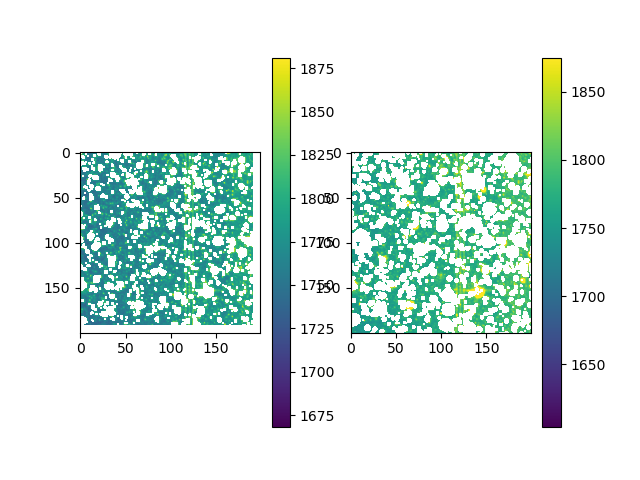

<IPython.core.display.Javascript object>


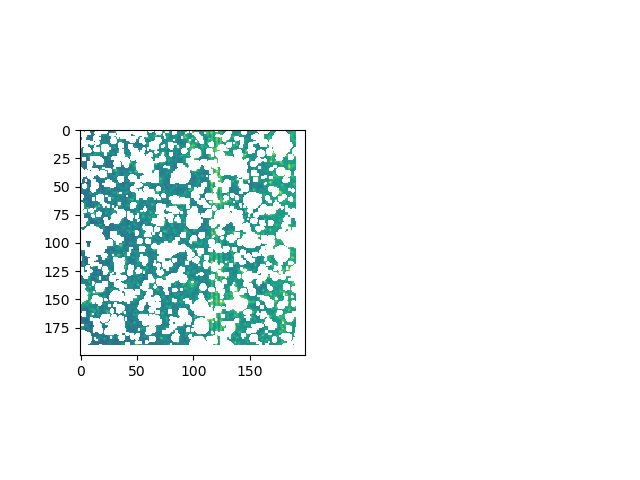

In [616]:
plt.figure()
plt.subplot(121)
plt.imshow(b*cut.data)
plt.colorbar()
plt.subplot(122)
plt.imshow(eh*cut.data,vmax=1875)
plt.colorbar()

plt.figure()
plt.subplot(121)
plt.imshow(b*eh*cut.data)

In [672]:
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN

In [815]:
dat = cut.data.astype(float)
dat = f.astype(float)
dat = dat[:,90+44]
dat = dat[dat > 10]
#dat = dat[dat < np.percentile(dat,80)]

<IPython.core.display.Javascript object>


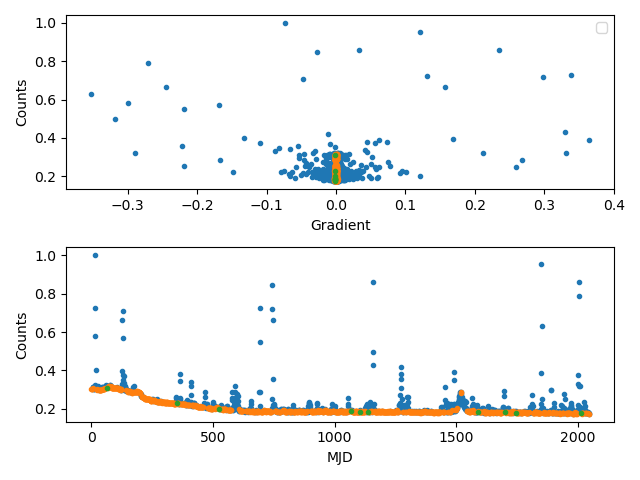

No handles with labels found to put in legend.


In [817]:
lc = np.array([np.arange(0,len(dat)),dat/np.nanmax(dat)])
arr = np.array([np.gradient(lc[1]),np.gradient(np.gradient(lc[1]))])
#clust = OPTICS(min_samples=6, xi=.05, min_cluster_size=.05)
clust = DBSCAN(eps=.0003,min_samples=10)
opt = clust.fit(arr.T)
lab = opt.labels_
keys = np.unique(opt.labels_)

# lets see how well the clustering did 
colours = ['grey','C0','C1','C2']
labels = ['Outliers','Background','eh','b']
plt.figure()
plt.subplot(211)
for i in range(len(keys)):
    plt.plot(np.gradient(lc[1])[lab==keys[i]],lc[1,lab==keys[i]],'.')#,color=colours[i],label=labels[i])
plt.ylabel('Counts')
plt.xlabel('Gradient')
plt.legend()  

plt.subplot(212)
for i in range(len(keys)):
    plt.plot(lc[0,lab==keys[i]],lc[1,lab==keys[i]],'.')#,color=colours[i])
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.tight_layout()

In [761]:
keys

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [970]:
data = f.astype(float)
#dat = data[:2048,44:44+2048]
mask = np.zeros_like(data)
for i in range(data.shape[1]):
    #i = 100#1029
    if (data[:,i] > 10).any():
        clip = (data[:,i] > 10)
        lc = data[clip,i]/np.nanmax(data[clip,i])
        #plt.figure()
        #plt.plot(lc)
        grad = np.gradient(lc)
        accel = np.gradient(grad)
        arr = np.array([grad,accel])

        clust = DBSCAN(eps=.0003,min_samples=20)
        opt = clust.fit(arr.T)
        lab = opt.labels_
        keys = np.unique(opt.labels_)
        ind = 1
        for j in range(len(keys)-1):
            if sum(lab==keys[j+1]) > sum(lab==keys[ind]):
                ind = j+1
        bkgind = lab==keys[ind]
        #print(sum(bkgind))
        lim = np.percentile(lc,80)
        bkgind[(lc > lim)] = False
        #print(sum(bkgind))
        #print(bkgind.any())
        #thing = 
        mask[clip,i] = bkgind *1 
        #print(sum(mask[clip,i]))
        #
        #plt.figure()
        #arr = np.arange(len(lc))
        #for i in range(len(keys)):
        #    plt.plot(arr[lab==keys[i]],lc[lab==keys[i]],'.')

In [953]:
np.sum(mask2,axis=1)

array([3., 3., 2., ..., 0., 0., 0.])

In [844]:
mask[clip,i][bkgind]

array([1., 1., 1., ..., 1., 1., 1.])

<IPython.core.display.Javascript object>


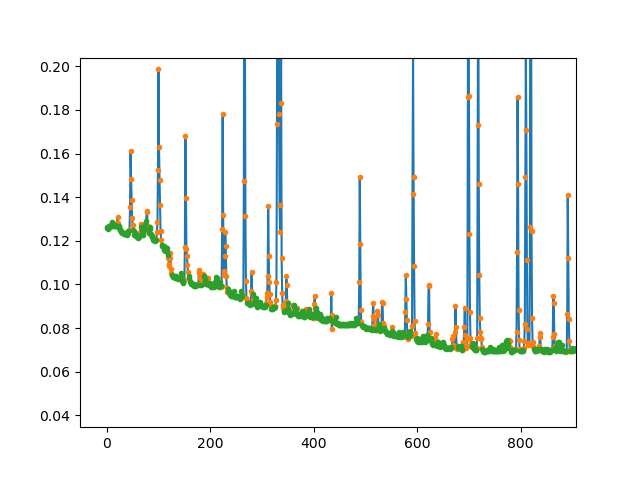

In [827]:
plt.figure()
plt.plot(lc)
arr = np.arange(len(lc))
for i in range(len(keys)):
    plt.plot(arr[lab==keys[i]],lc[lab==keys[i]],'.')

<IPython.core.display.Javascript object>


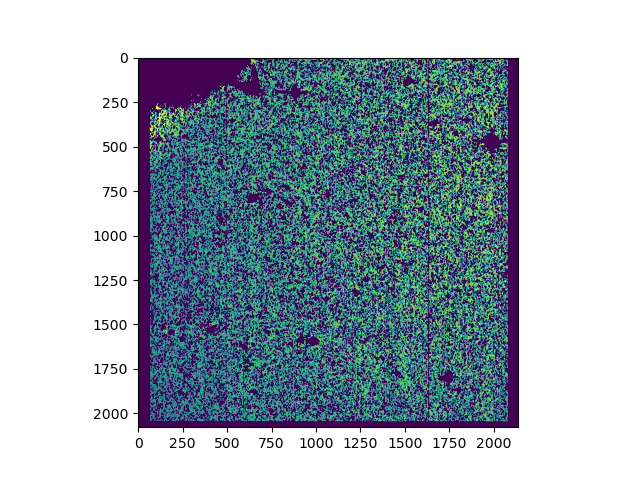

In [973]:
plt.figure()
plt.imshow(mask*data,vmin=1000,vmax=2000)
plt.figure()
plt.imshow(bkm*data,vmin=1000,vmax=2000)

In [798]:
dat.shape

(2048, 2048)

In [791]:
data[:2048,44:44+2048]

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

In [792]:
dat.shape

(2018,)

<IPython.core.display.Javascript object>


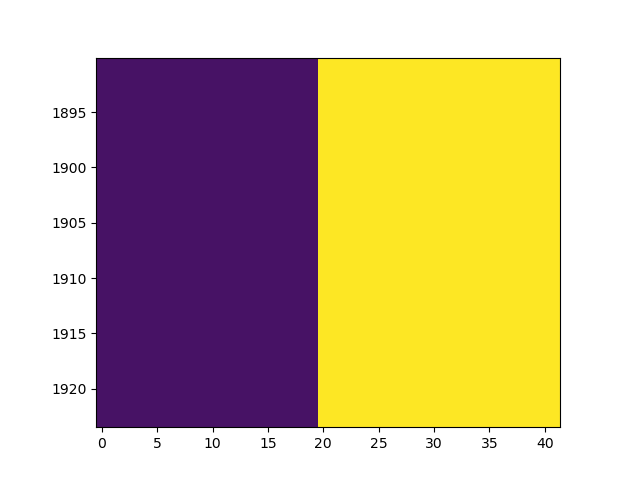

In [795]:

plt.figure()
plt.imshow(data[:2048,44:44+2048],vmin=0,vmax=100)

In [796]:
data[:2048,44:44+2048].shape

(2048, 2048)

In [650]:
np.nanstd(arr[0])

0.047077830764043496

In [663]:
gg

array([-6.86597615e-05, -1.24568424e-03, -3.28586001e-03, -1.55955744e-03,
       -5.68895166e-04, -1.86362210e-04, -2.74639046e-03, -2.64830508e-03,
       -1.00047081e-03, -4.31575643e-04, -1.56936598e-04, -1.47128060e-04,
       -1.96170747e-05, -9.80853735e-06, -1.96170747e-05, -7.84682988e-05,
       -9.80853735e-05, -9.80853735e-06, -2.55021971e-04, -3.04064658e-04,
       -4.02150031e-04, -3.43298807e-04, -1.66745135e-04, -2.45213434e-04,
       -9.80853735e-06, -2.23634652e-03, -1.03970496e-03, -6.86597615e-05,
       -1.37025267e-02, -2.82485876e-02, -6.89540176e-03, -1.85381356e-03,
       -4.80618330e-04, -5.68895166e-04, -3.38394539e-03, -1.58898305e-03,
       -8.23917137e-04, -3.91360640e-03, -1.82438795e-03, -1.01027935e-03,
       -3.53107345e-04, -5.98320778e-04, -2.31089140e-02, -2.31481481e-02,
       -8.47457627e-03, -2.61887947e-03, -8.92576899e-04, -3.53107345e-04,
       -1.17702448e-04, -4.90426868e-04, -2.05979284e-04, -3.92341494e-05,
       -1.56936598e-04, -

<IPython.core.display.Javascript object>


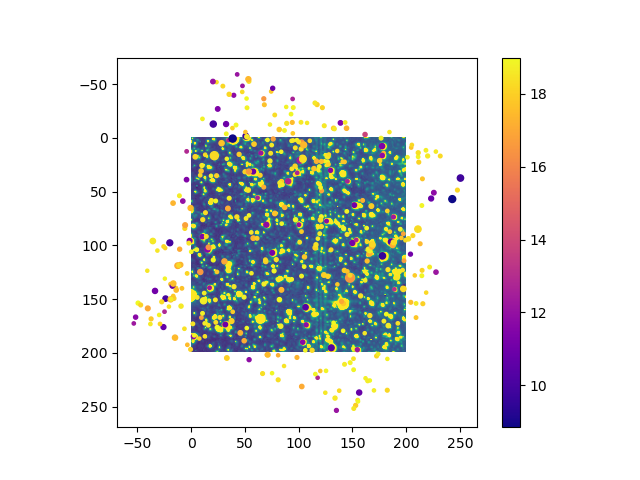

<IPython.core.display.Javascript object>


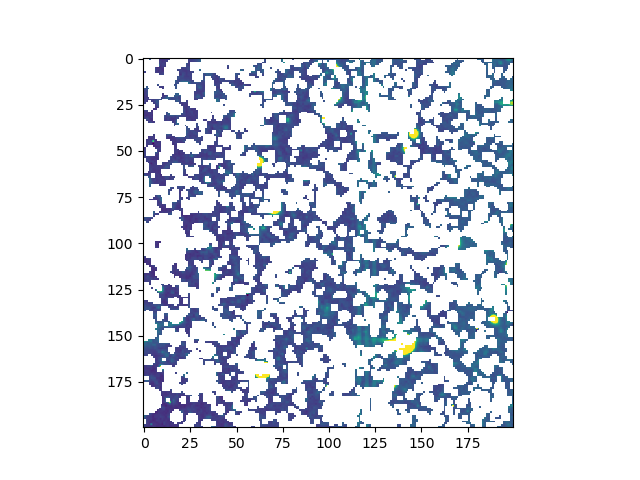

<IPython.core.display.Javascript object>


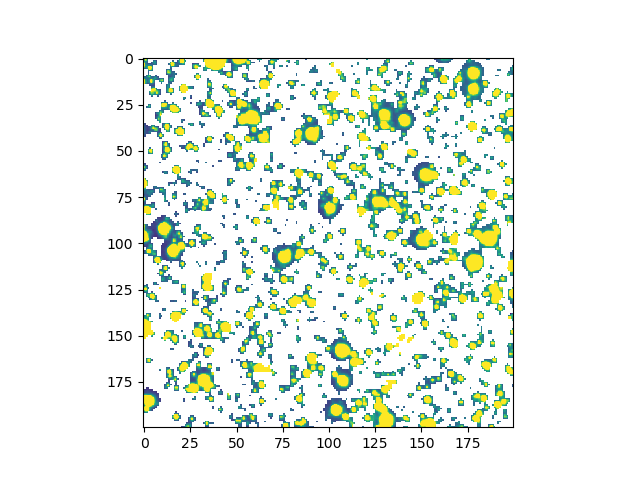

In [573]:
plt.figure()
plt.imshow(dat,vmin=1700,vmax=2000)
r = sources.raMean.values
d = sources.decMean.values
p = cut.wcs.all_world2pix(r,d,0)#[a<-1,:]
#eh = plt.scatter(p[0],p[1],s=10**(-2/5*(sources.iMeanPSFMag-25))/1e3,c=sources.iMeanPSFMag,cmap='plasma')
ind = ik > 5
eh = plt.scatter(p[0][ind],p[1][ind],s=ik[ind],c=sources.iMeanPSFMag.iloc[ind],cmap='plasma')
plt.colorbar(eh)

plt.figure()
mask = (np.nansum(bol,axis=0)>0)*1.
mask[mask!=0] =np.nan
plt.imshow( (mask+1)* dat,vmin=1700,vmax=2000)

plt.figure()
mask = (np.nansum(bol,axis=0)>0)*1.
mask[mask==0] =np.nan
plt.imshow( (mask)* dat,vmin=1700,vmax=2000)

In [561]:
cut.wcs.all_pix2world(145,43,0)

[array(189.85408571), array(7.92566723)]

<IPython.core.display.Javascript object>


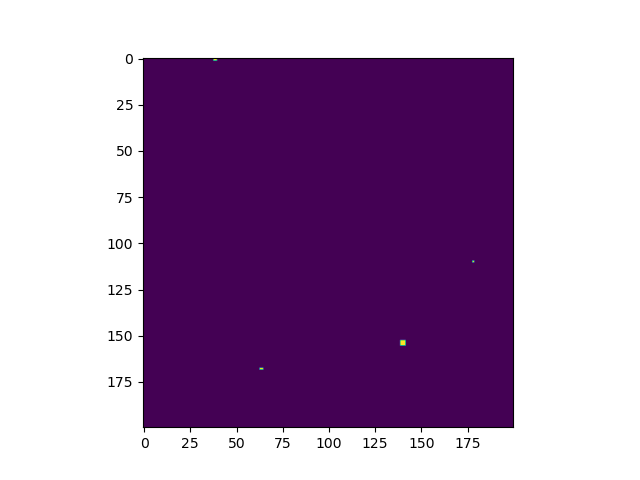

In [558]:
plt.figure()
plt.imshow((m.data))

In [423]:
cut.to_original_position((178,8))

(331, 8)

# saturated

In [518]:
cut = Cutout2D(f,(891,206),200,wcs=wcs)
sources = PS1_mean_detections(cut.wcs)

In [519]:
dat = cut.data

r = sources.raMean.values
d = sources.decMean.values
p = cut.wcs.all_world2pix(r,d,0)
tx = np.arange(0,dat.shape[0])
ty = np.arange(0,dat.shape[1])
tx,ty = np.meshgrid(tx,ty)
dists = ((tx[np.newaxis,:,:] - p[0][:,np.newaxis,np.newaxis])**2 +  (ty[np.newaxis,:,:] - p[1][:,np.newaxis,np.newaxis])**2)

<IPython.core.display.Javascript object>


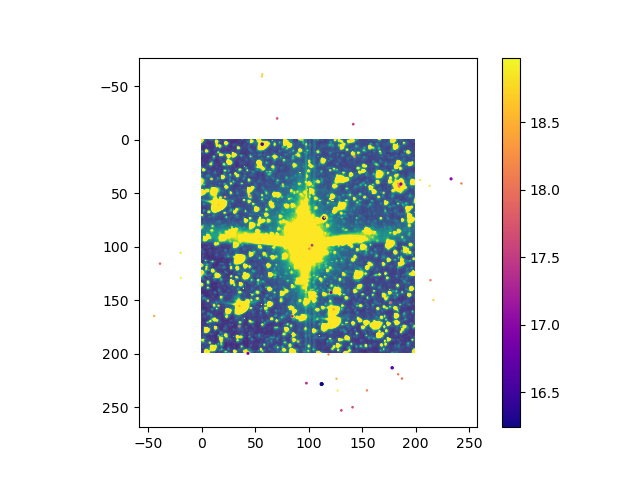

<IPython.core.display.Javascript object>


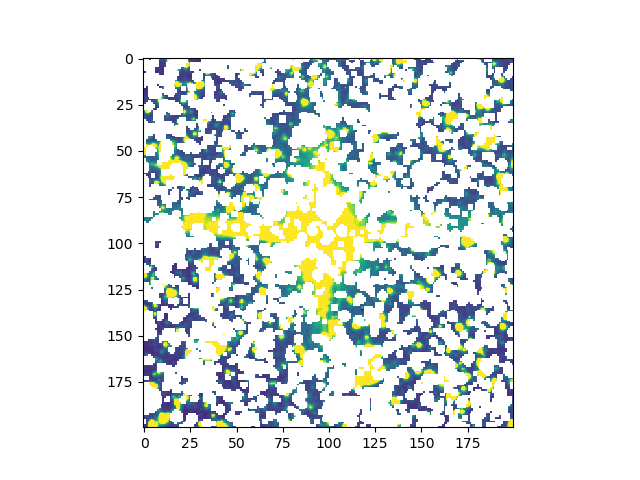

<IPython.core.display.Javascript object>


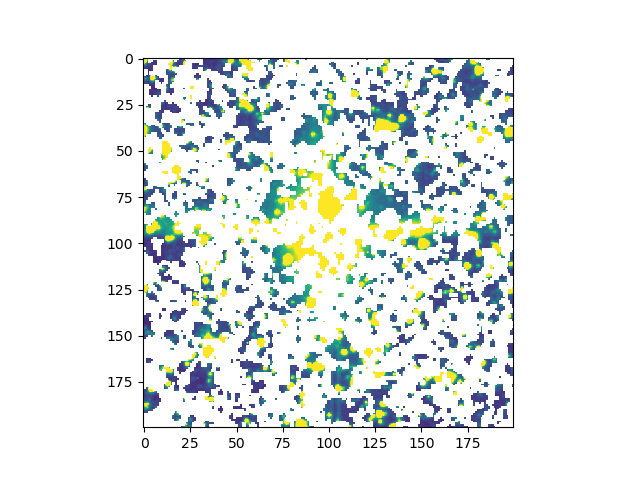

In [524]:
plt.figure()
plt.imshow(dat,vmin=1700,vmax=2000)
r = sources.raMean.values
d = sources.decMean.values
p = cut.wcs.all_world2pix(r,d,0)#[a<-1,:]
#eh = plt.scatter(p[0],p[1],s=10**(-2/5*(sources.iMeanPSFMag-25))/1e3,c=sources.iMeanPSFMag,cmap='plasma')
ind = (sources.iMeanPSFMag-sources.iMeanKronMag).values >1.5
eh = plt.scatter(p[0][ind],p[1][ind],s=10**(-2/5*(sources.iMeanPSFMag.iloc[ind]-25))/1e3,c=sources.iMeanPSFMag.iloc[ind],cmap='plasma')
plt.colorbar(eh)

plt.figure()
mask = (np.nansum(bol,axis=0)>0)*1.
mask[mask!=0] =np.nan
plt.imshow( (mask+1)* dat,vmin=1700,vmax=2000)

plt.figure()
mask = (np.nansum(bol,axis=0)>0)*1.
mask[mask==0] =np.nan
plt.imshow( (mask)* dat,vmin=1700,vmax=2000)

In [522]:
wcs.all_pix2world(331,8,0)

[array(184.41635072), array(4.63145253)]

In [ ]:
cut.writeto('/Users/rridden/Desktop/test.fits')

In [421]:
from 

[array(183.66916499), array(4.96059142)]

In [354]:
ps1 = sd.PS1_images(183.12801737,6.17478271,30,['i','z','y'])

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


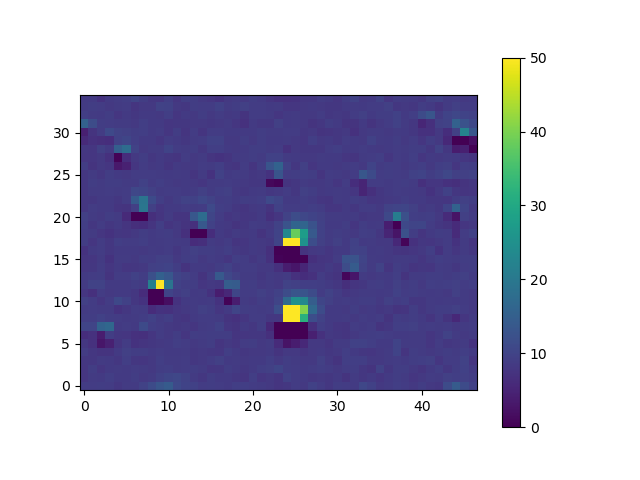

In [425]:
plt.figure()
#plt.subplot(projection=cut.wcs)
plt.imshow(dat,vmax=50,vmin=0,origin='lower')
plt.colorbar()

#plt.contour(ps1['i'])

In [737]:
f = fits.open('../../../../data/tess/pipe/test/s0023_58939.901_0591_3.sw.diff.fits')[0].data
f = fits.open('../../../../data/tess/pipe/test/s0023_58939.901_0591_3.sw.fits')[0].data
f2 = fits.open('../../../../data/tess/pipe/test/s0023_58929.380_0086_3.sw.diff.fits')[0].data
wcs = WCS('../../../../data/tess/pipe/test/s0023_58939.901_0591_3.sw.diff.fits')
wcs2 = WCS('../../../../data/tess/pipe/test/s0023_58929.380_0086_3.sw.diff.fits')

<IPython.core.display.Javascript object>


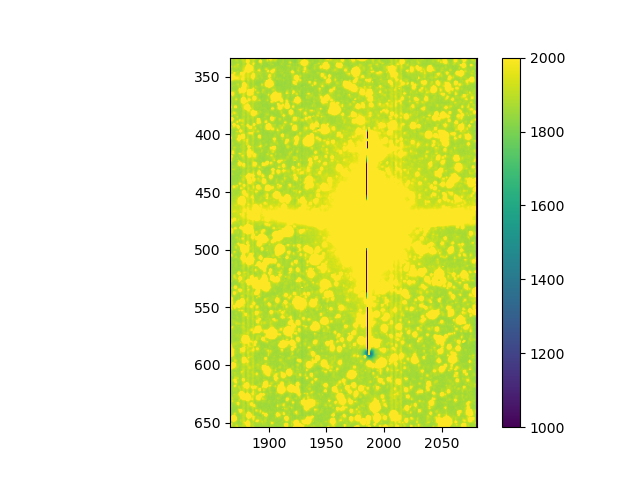

In [743]:
plt.figure()
plt.imshow(abs(f),vmax=2000,vmin=1000)
#plt.imshow(abs(f2))#,vmax=1000,vmin=400)
plt.colorbar()

In [341]:
m = abs(f) > np.percentile(abs(f),95)

In [342]:
m*1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<IPython.core.display.Javascript object>


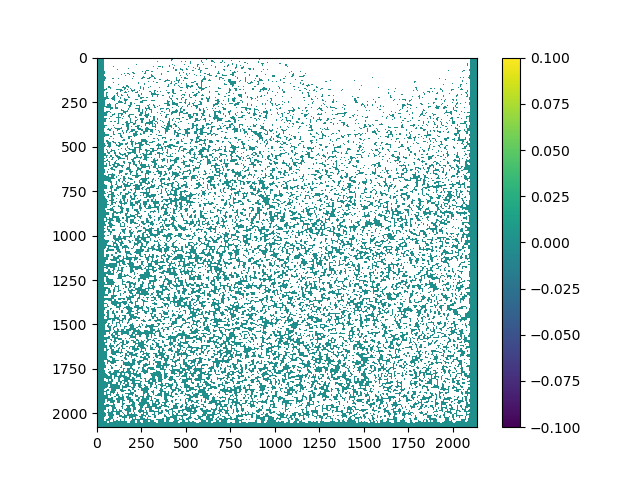

In [343]:
b = m*1.
b[b!=0] = np.nan
plt.figure()
plt.imshow(b*f)
plt.colorbar()

In [193]:
from astropy.wcs import WCS

In [196]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 189.96670052432867  8.231092665619656  
CRPIX : 1045.0  1001.0  
CD1_1 CD1_2  : 0.005269707001844709  0.00205247561713  
CD2_1 CD2_2  : -0.002187362479478  0.00532540252385405  
NAXIS : 2136  2078

In [197]:
test = PS1_cat(wcs)

ReadTimeout: HTTPConnectionPool(host='vizier.u-strasbg.fr', port=80): Read timed out. (read timeout=60)

In [1006]:
s = wcs.array_shape
ra, dec = wcs.all_pix2world(s[0]/2,s[1]/2,0)
r = ((1/2*np.sqrt(s[0]**2+s[1]**2) + 10) * 24)/60

f = wcs.calc_footprint()

ramin = min(f[:,0])
ramax = max(f[:,0])
decmin = min(f[:,1])
decmax = max(f[:,1])

queryMean = """select r.RA, r.Dec, r.Gaia, r.i, r.z
from fGetNearbyObjEq({ra},{dec},{rad}) as n
INNER JOIN refcat2 as r on n.objid=r.objid
WHERE r.i < 19
""".format(ra=ra,dec=dec,rad=r,ramin=ramin,ramax=ramax,decmin=decmin,decmax=decmax)

In [1007]:

queryMean

'select r.RA, r.Dec, r.Gaia, r.i, r.z\nfrom fGetNearbyObjEq(190.08143366297801,8.604570917416329,600.0060402378487) as n\nINNER JOIN refcat2 as r on n.objid=r.objid\nWHERE r.i < 19\n'